# Beginner-Friendly Machine Learning Tutorial: Titanic Dataset

Welcome! This notebook will guide you step-by-step through a hands-on machine learning workflow using the Titanic dataset. You will learn how to:

- Load and explore data
- Preprocess and clean data
- Build and evaluate a machine learning model
- Visualize results

Let's get started!

In [1]:
# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

## 1. Setup: Import Libraries and Configure Environment

Let's import the necessary Python libraries and set up our environment.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from src.utility import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### About the Custom Machine Learning Classes

This notebook uses several custom classes from `utility.py` to simplify and enhance the machine learning workflow:

- **FeatureEngineeringSelector**: Flexible feature selection and engineering.
- **DataFramePreprocessor**: Handles missing values, scaling, encoding, and duplicate removal.
- **GraphAnalyzerEngine**: Analyzes feature importances and relationships.
- **VisualizerFactory**: Provides advanced visualizations.

These tools make the machine learning process more accessible and interpretable.

## 2. Load and Explore the Titanic Dataset

The Titanic dataset contains information about passengers and whether they survived. Let's load the data and take a first look.

In [3]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 3. Data Preprocessing: Feature Selection and Cleaning

To prepare our data for machine learning, we need to:
- Separate features (inputs) from the target (output)
- Clean and preprocess the data (handle missing values, encode categories, etc.)

**Note:** The ['sex', 'embarked', 'who', 'embark_town', 'alive', 'class', 'deck'] columns are categorical and will be encoded.


In [4]:
preproc = DataFramePreprocessor(
        fill_strategy='drop',  # 'drop', 'fill', or 'none'
        fill_method='mean',
        encoding='label'
    )
titanic_clean = preproc.fit_transform(titanic)
label_map = preproc.get_label_mapping()
print("Label Mapping:", label_map)
titanic_clean.head()

Label Mapping: {'sex': {0: 'female', 1: 'male'}, 'embarked': {0: 'C', 1: 'Q', 2: 'S', 3: 'nan'}, 'who': {0: 'child', 1: 'man', 2: 'woman'}, 'embark_town': {0: 'Cherbourg', 1: 'Queenstown', 2: 'Southampton', 3: 'nan'}, 'alive': {0: 'no', 1: 'yes'}, 'class': {0: 'First', 1: 'Second', 2: 'Third'}, 'deck': {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'nan'}}


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,0,38.0,1,0,71.2833,0,0,2,0,2,0,1,0
3,1,1,0,35.0,1,0,53.1000,2,0,2,0,2,2,1,0
6,0,1,1,54.0,0,0,51.8625,2,0,1,1,4,2,0,1
10,1,3,0,4.0,1,1,16.7000,2,2,0,0,6,2,1,0
11,1,1,0,58.0,0,0,26.5500,2,0,2,0,2,2,1,1


In [5]:
label_map.keys()

dict_keys(['sex', 'embarked', 'who', 'embark_town', 'alive', 'class', 'deck'])

In [13]:
out = preproc.dataset_overview(titanic_clean)
print("Dataset Overview:\n", out.keys())

Dataset Overview:
 dict_keys(['stats', 'correlation_matrix', 'colinear_pairs'])


In [17]:
out['colinear_pairs']

[('survived', 'alive', 1.0),
 ('pclass', 'class', 1.0000000000000002),
 ('sex', 'adult_male', 0.9259237692314486),
 ('embarked', 'embark_town', 1.0)]

In [14]:
out['stats'].head()

,variance,unique_values,nan_counts,dtype
survived,0.220296,2,0,int64
pclass,0.266681,3,0,int64
sex,0.251108,2,0,int32
age,245.599528,63,0,float64
sibsp,0.416034,4,0,int64


In [18]:
# Drop rows with missing target (survived)
titanic = titanic_clean.copy()
# Separate features (X) and target (y), remove the alive because it is redundant 
# 'colinear_pairs': [('survived', 'alive', 1.0 in report 

X = titanic.drop(columns=['survived', 'alive'])
y = titanic['survived']


In [19]:
strategies = [
    {
        "name": "model_importance",
        "model_cls": RandomForestClassifier,
        "threshold": "mean"
    },
    # {
    #     "name": "pca",
    #     "n_components": 2
    # }
]

fes = FeatureEngineeringSelector(
    strategies=strategies,
    problem_type='classification',
    random_state=42
)

X_transformed = fes.fit_transform(X, y)
# --- 5. Résultats ---
print("✓ Features sélectionnées :", fes.get_support())
print("✓ Historique des étapes :")
for step in fes.get_history():
    print("  •", step)
print("✓ Forme du jeu transformé :", X_transformed.shape)
print("\nAperçu du résultat :")
X_transformed.head()

✓ Features sélectionnées : ['sex', 'age', 'fare', 'who', 'adult_male', 'deck']
✓ Historique des étapes :
  • {'step': 'model_importance', 'selected': ['sex', 'age', 'fare', 'who', 'adult_male', 'deck'], 'importances': [0.016651265241357696, 0.09929209841029228, 0.231111217164062, 0.030674320817014378, 0.02924170611555681, 0.2093464319586534, 0.01881858781418483, 0.01381895881293537, 0.08984525721925278, 0.13416651495554596, 0.09240573513372567, 0.01676978535906895, 0.017858120998349988]}
✓ Forme du jeu transformé : (182, 6)

Aperçu du résultat :


,sex,age,fare,who,adult_male,deck
1,0,38.0,71.2833,2,0,2
3,0,35.0,53.1000,2,0,2
6,1,54.0,51.8625,1,1,4
10,0,4.0,16.7000,0,0,6
11,0,58.0,26.5500,2,0,2


## 4. Model Training and Evaluation

Now, let's train a machine learning model to predict survival. We'll:
- Split the data into training and test sets
- Train a Random Forest classifier
- Evaluate the model's performance using a classification report and confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63        18
           1       0.76      0.79      0.77        28

    accuracy                           0.72        46
   macro avg       0.70      0.70      0.70        46
weighted avg       0.71      0.72      0.72        46



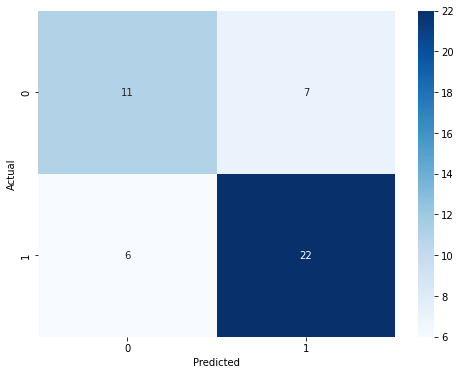

In [9]:
pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_transformed,
                                                    y, random_state=42)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

## 5. Feature Importance and Visualization

Let's use advanced visualizations to explore feature importances and relationships.

In [10]:
engine = GraphAnalyzerEngine()
engine.analyze(X_transformed, pd.DataFrame(y))
store = engine.get_store()
relabel_targets_in_store(store, label_map)
fig_sankey = VisualizerFactory.make_sankey(store, show_feature_feature_links=False)
fig_sankey.show()

### Bar Plot of Feature Importances

The bar plot below shows the aggregated importance of each feature. The dashed line represents the threshold for random (noise) importance. Features above this line are considered informative.

In [11]:
fig_bar = VisualizerFactory.make_bar(store, show_threshold=True, show_noise=True)
fig_bar.show()

In [12]:
# Plot t-SNE map for feature visualization
fig_tsne = VisualizerFactory.make_tsne(X_transformed, y,
                                    perplexity=30,
                                    random_state=10)
fig_tsne.show()

## 6. Conclusion and Next Steps

Congratulations! You have completed a full machine learning workflow on the Titanic dataset:
- Data loading and exploration
- Preprocessing and cleaning
- Model training and evaluation
- Feature importance analysis and visualization

Feel free to experiment with different models, parameters, or datasets!